<img src="skoltech_logo.png" alt="Skoltech" width=60% height=60% />
<h1 style="color:#333333; text-align:center; line-height: 0;">Reinforcement Learning</h1>
<h5 style="color:#333333; text-align:center;">Course MA030422</h5>

<h2 style="color:#A7BD3F;">Lab 2</h2>

***

### Goal of this lab

The purpose of this lab is to:
1. Introduce you to the the gym-minigrid environment
2. Practice creating and training neural networks in Pytorch for the purpose of applying them as function approximators in RL.
3. Solve the gym-minigrid environment with a cross entropy RL algorithm

### Components

* **Section 1**: OpenAI <b style="color:blue;">Gym-Mingrid</b> environment
* **Section 2**: Neural networks in Pytorch
    * Exercise 1 - Training a neural network
        * Problem 1.1 (15 points) 
* **Section 3**: Neural networks in Pytorch
    * Exercise 2 - Solving Minigrid 5x5
        * Problem 2.1 (5 points)
        * Problem 2.2 (15 points)
        * Problem 2.3 (2 points)
        
Total points: 37

<h2 style="color:#A7BD3F;">Imports and Autograder</h2>

***
Take care of imports early on:

In [1]:
# torch
import torch
import torch.nn as nn
import torch.optim as optim

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# gym
import gym
from gym import wrappers
import gym_minigrid
from gym_minigrid.minigrid import IDX_TO_OBJECT
from gym_minigrid.wrappers import ImgObsWrapper, OneHotPartialObsWrapper

# others
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
import random
from collections import namedtuple
from tensorboardX import SummaryWriter
from IPython import display
from grading_utilities import AnswerTracker

### <font color="orange">Auto-grading</font>
Run this cell to track your answers

In [2]:
### GRADING DO NOT MODIFY
lab2_answers = AnswerTracker()

<h2 style="color:#A7BD3F;">Section 1 - Environment</h2>

***

### Intro to OpenAI <i style="color:blue;">gym minigrid</i> environment

In lab 2 we will be exploring agent training in an grid world environment called *gym-minigrid*, seen [here](https://github.com/maximecb/gym-minigrid). The environment has the following characteristics <sup>[1]</sup>:

<blockquote cite="https://github.com/maximecb/gym-minigrid"><h4>Structure of the world:</h4>

* The world is an NxM grid of tiles
* Each tile in the grid world contains zero or one object
* Cells that do not contain an object have the value None
* Each object has an associated discrete color (string)
* Each object has an associated type (string)
* Provided object types are: wall, floor, lava, door, key, ball, box and goal
* The agent can pick up and carry exactly one object (eg: ball or key)
* To open a locked door, the agent has to be carrying a key matching the door's color

#### Actions in the basic environment:

* Turn left
* Turn right
* Move forward
* Pick up an object
* Drop the object being carried
* Toggle (open doors, interact with objects)
* Done (task completed, optional)
* Default tile/observation encoding:

<br />
Each tile is encoded as a 3 dimensional tuple: (OBJECT_IDX, COLOR_IDX, STATE)</blockquote>

### About the agent

From <sup>[2]</sup>:
>Observations in MiniGrid are partial and egocentric. By default, the agent sees a square of 7x7 tiles in the direction it is facing. These include the tile the agent is standing on. The agent cannot see through walls or closed doors. **The observations are provided as a tensor of shape 7x7x3**. However, note that these are not RGB images. Each tile is encoded using 3 integer values: one describing the type of object contained in the cell, one describing its color, and a state indicating whether doors are open, closed or locked. This compact encoding was chosen for space efficiency and to enable faster training. The fully observable RGB image view of the environments shown in this paper is provided for human viewing.

To ease the computational burden of training (and for the sake of learning) - we will be training on a small 5x5 grid (it's really 3x3, as 5x5 includes walls):

<img src="minigrid_5x5.png" alt="Gym Minigrid" width=30% height=30% />

The picture below demonstrates an 8x8 grid (including walls):

<img src="minigrid.png" alt="Gym Minigrid" width=40% height=40% />

Notice the highlighted cells? That is actually the agent's view of the environment. As mentioned in the quoted text above, the agent's view is codifed as 7x7x3 tensor, and it appears as such (run the following cell):

In [3]:
# specify env name
env_name = "MiniGrid-Empty-6x6-v0"

# instantiate env
env = gym.make(env_name)

# apply wrapper
env = ImgObsWrapper(env)

# reset env to assign first obv
obs = env.reset()
obs

array([[[2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0]],

       [[2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0]],

       [[2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0]],

       [[2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]],

       [[2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]],

       [[2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]],

       [[2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [8, 1, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]]], dtype=uint8)

The first 2 dimensions of the tensor above have 7 elements each which signify the y and x coordinates, respectively, of the agent's observational field view. Note:
* The y-axis starts from the top of the figure and moves downwards. 
* The agent's observational view may start **beyond** the confines of the grid

The third dimension (of 3 elements) specifies <sup>[1]</sup>:
* The type of object contained in the cell,
* One describing its color,
* And a state indicating whether doors are open, closed or locked.

The object types (int) can be mapped to English representations:

In [6]:
IDX_TO_OBJECT

{0: 'unseen',
 1: 'empty',
 2: 'wall',
 3: 'floor',
 4: 'door',
 5: 'key',
 6: 'ball',
 7: 'box',
 8: 'goal',
 9: 'lava',
 10: 'agent'}

Let's map the agent's integer-based observational-field-tensor to a unicode, string-based representation using the dict above:

In [13]:
mapped_obs = np.empty((7,7,3), dtype='<U6')

for key, val in IDX_TO_OBJECT.items():
    mapped_obs[obs == key] = val
    
mapped_obs

array([[['wall', 'key', 'unseen'],
        ['wall', 'key', 'unseen'],
        ['wall', 'key', 'unseen'],
        ['wall', 'key', 'unseen'],
        ['wall', 'key', 'unseen'],
        ['wall', 'key', 'unseen'],
        ['wall', 'key', 'unseen']],

       [['wall', 'key', 'unseen'],
        ['wall', 'key', 'unseen'],
        ['wall', 'key', 'unseen'],
        ['wall', 'key', 'unseen'],
        ['wall', 'key', 'unseen'],
        ['wall', 'key', 'unseen'],
        ['wall', 'key', 'unseen']],

       [['wall', 'key', 'unseen'],
        ['wall', 'key', 'unseen'],
        ['wall', 'key', 'unseen'],
        ['wall', 'key', 'unseen'],
        ['wall', 'key', 'unseen'],
        ['wall', 'key', 'unseen'],
        ['wall', 'key', 'unseen']],

       [['wall', 'key', 'unseen'],
        ['wall', 'key', 'unseen'],
        ['wall', 'key', 'unseen'],
        ['empty', 'unseen', 'unseen'],
        ['empty', 'unseen', 'unseen'],
        ['empty', 'unseen', 'unseen'],
        ['empty', 'unseen', 'unseen']

The mapped observations above confirm that the agent sees the goal in:
* the 7th cell **down** (7th coordinate on the y-axis, which is the 6th indice of the 1st dimension of the `obs` tensor)
* and the 4th cell **across** (4th cell on the x-axis, which is the 3rd indice of the 2nd dimension of the `obs` tensor)
* Remember: The indices of container objects (lists, tuples, arrays, tensors, etc) in Python start from 0, not 1

Below we retrieve the **indices** of the cell at Euclidean coordinates (7, 4) from the mapped observations:

In [14]:
y, x, _ = np.where(mapped_obs=='goal')
y.item(), x.item()

(6, 3)

Now let's review and confirm these numbers visually:

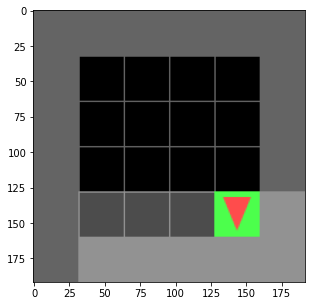

In [15]:
env.step(2)
#env.step(3)
#env.step(1)

plt.figure(figsize=(5,5))
plt.imshow(env.render(mode='rgb_array', highlight=True))

Although the agent's observational field of view starts beyond the confines of the **grid**, we see the numbers are correct: the green goal cell is in the 7th cell down (6th indice) and 4th cell across (3rd indice) from the observational field (0,0) coordinate.

### Our goal

Our goal will be to train the agent to move to the green cell using function approximation with neural networks. Note that the gym-minigrid environment is customizable, and many interesting customizations are already provided in the repo above.

<h2 style="color:#A7BD3F;">Section 2 - Getting comfortable with Neural Networks</h2>

***

Before we get started with creating the algorithm to solve the environment, we need to understand how to create and train neural networks in Pytorch.

### Quick primer on neural networks

As discussed in homework 1, in RL there are 3 general types of functions:
* value functions
* policy function
* reward function

Unlike in homework 1, where we solved a discrete/finite state and action space MDP -- real world problems typically involve continuous state and action spaces, usually in more than 3 dimensions (more than 6 is rare).

To solve environments with ❗<font color="red">continuous</font> state and action spaces (often that do not provide any explicit transition probabilities or reward functions), we use statistical models for function approximation.

Of the various types of ML models available to us, the powerful abilities of neural networks make them among the more commonly selected for this task. This is because neural nets can model highly complex data, unstructured data, and are scalable to data size. Neural networks are often used in RL to approximate the **policy function**, specifically.

💡 The use of **multi-layer** neural networks as function approximators in RL is what gives the name **Deep** in *Deep RL*.

#### <font color="blue">Side track:</font>
If you're *completely* new to neural networks, checkout out the following links for a nice introduction:
* [Neural networks and deep learning](http://neuralnetworksanddeeplearning.com/chap1.html)
* [Tensorflow playground](https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.39899&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)
* [Intro to Deep Learning with Pytorch](https://pytorch.org/deep-learning-with-pytorch)
* [Deep Learning Wizard](https://www.deeplearningwizard.com)

Or message your instructors for good books on the subject.

### Demo of a neural network

The 3 most popular libraries for deep learning with Python are: Pytorch (developed by Facebook; open source), Tensorflow (developed by Google; open source), and Keras (built on top of Tensorflow; open source).

We will be using Pytorch, as it is my favorite DL library and is usually preferred by research scientists and other individuals who like maximum control over neural architectures and ease of tensor operations. If you're new to Pytorch, check out the following [Tutorials](https://pytorch.org/tutorials/).

Below, we demonstrate the basic structure of a 3 layer neural network with the aim to show you that it is simply a mathematical model.

### Create tensor

Below we create a tensor that contains random integers (converted to 32-bit float values) in the shape of 5 rows and 3 columns. The rows represent **training examples** and the columns represent **features**. So we have 5 training examples, each with 3 features.

In [16]:
# clear previous variables from memory
try:
    del x
    del y
    del env
except:
    pass

# set seed
torch.manual_seed(999)

# define number of training examples
num_training_examples = 5

# define number of features
num_features = 3

# define "dataset"
dataset = torch.randint(low=0, high=20, size=(num_training_examples,num_features), dtype=torch.float32)
dataset

tensor([[12., 16.,  1.],
        [ 5.,  8.,  9.],
        [ 7., 19.,  9.],
        [ 7.,  8.,  5.],
        [ 9., 16., 16.]])

### Create neural network

Next, we create a neural network with 3 linear layers. Check out Pytorch's docs on the [Linear layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear) for more info.

In [17]:
# create architecture of binary logistic regression classifier
class BinaryLogisticRegression(nn.Module):
    def __init__(self, x_dim, out1 = 16, out2 = 32, out3=64):
        super(BinaryLogisticRegression, self).__init__()

        # instantiate linear layers
        self.linear1 = torch.nn.Linear(x_dim, out1)
        self.linear2 = torch.nn.Linear(out1, out2)
        self.linear3 = torch.nn.Linear(out2, out3)
        self.linear4 = torch.nn.Linear(out3, 1)
        

    def forward(self, x):
        # apply ReLU activation to linear layer 1
        x = torch.relu(self.linear1(x))
        
        # apply ReLU activation to linear layer 2
        x = torch.relu(self.linear2(x))
        
        # apply ReLU activation to linear layer 2
        x = torch.relu(self.linear3(x))
        
        # apply Sigmoid activation to linear layer 3
        y = torch.sigmoid(self.linear4(x))
        return y


# instantiate the classifier
neural_net = BinaryLogisticRegression(num_features)

### Pass the dataset of size 5x3 to the network

Now pass the dataset $X$ to the neural net to output $Y$:

In [18]:
y = neural_net(dataset)
y

tensor([[0.2894],
        [0.3637],
        [0.3076],
        [0.3595],
        [0.2579]], grad_fn=<SigmoidBackward>)

### Threshold
Next, categorize $Y$ according to a threshold of 0.5 to classify the training examples into 2 classes.

In [19]:
y_classes = torch.where(y > 0.5, torch.tensor(1), torch.tensor(0))
y_classes

tensor([[0],
        [0],
        [0],
        [0],
        [0]])

#### <font color="red">Note:</font> Remember - this model is not trained - this is just for example.

Through the process of training the neural network on thousands of examples it learns to accurately map the input data $X$ to $Y$, and can be applied to multinomial classification as well as much more interesting supervised tasks.

### What about network parameters?

How many parameters/coefficients does the network have? After all, these are the very coefficients that are optimized to **accurately** map $X$ to  $Y$ (a neural network is not fancy code - but a statistical model).

Let's find out:

In [20]:
# Function to count number of parameters in Pytorch neural network
def count_parameters(model, view_by_layer = False):
    if view_by_layer is True:
        tensor_list = model.state_dict().items()
        total_params = [] 
        
        for layer_name, tensor in tensor_list:
            num_elements = torch.numel(tensor)
            total_params.append(num_elements)
            print(f'Layer name {layer_name}: {num_elements} elements')

        print(f"Total parameters: {sum(total_params)}\n")
        
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_parameters = count_parameters(neural_net, view_by_layer = True)
num_parameters

Layer name linear1.weight: 48 elements
Layer name linear1.bias: 16 elements
Layer name linear2.weight: 512 elements
Layer name linear2.bias: 32 elements
Layer name linear3.weight: 2048 elements
Layer name linear3.bias: 64 elements
Layer name linear4.weight: 64 elements
Layer name linear4.bias: 1 elements
Total parameters: 2785



2785

### Takeaway

As we can see - this network of only 3 layers with 16, 32, and 1 hidden units each contains 641 parameters (including weights and biases). That's a long polynominal to make predictions for such a small 3-dimensional feature dataset.

Neural networks with even a couple layers can be powerful approximators of policy and value functions in reinforcement learning. 

Next, let's train a neural network on the Wine dataset from Kaggle.

### <font color="blue">Exercise 1: Training a neural network</font>


If a GPU is available to train on (which we're not counting on for this lab), we specify the device:

In [21]:
skip_training = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [22]:
device = torch.device('cpu')

In [23]:
device

device(type='cpu')

#### About the dataset

We'll be performing a binary classification training task with the Wine Dataset, originally from [here](https://archive.ics.uci.edu/ml/datasets/wine). Notes:
* Our dataset consists of both red and white wines. 
* There are 11 predictor variables and 1 target variable

#### Import the dataset

Import the dataset from csv to pandas dataframes:

In [24]:
# pandas df
df = pd.concat([
    pd.read_csv('winequality-red.csv', delimiter=';'),
    pd.read_csv('winequality-white.csv', delimiter=';')
])

num_features = df.shape[1]-1

print("Data shape: ", df.shape)

Data shape:  (6497, 12)


In [25]:
# view top 5 rows
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


The 'quality' column is our y-label/target column. Let's view the distinct values for quality:

In [26]:
sorted_labels = sorted(df.quality.unique())
num_classes = len(sorted_labels)
sorted_labels

[3, 4, 5, 6, 7, 8, 9]

The quality of wines in this dataset are categorized by discrete values ranging from 3 to 9.

#### Convert labels for binary classification

#### ❗ Classification Task: 
➡️ We will be predicting whether the quality of a wine is greater than or equal to 7. So we need to convert the y-labels into 2 classes (0 - less than 7, and 1 - greater than or equal to 7):

In [27]:
if 0 not in df['quality'].values:
    df['quality'] = np.where((df.quality >= 7), 1.0 , 0.0)

df['quality'].tail()

4893    0.0
4894    0.0
4895    0.0
4896    1.0
4897    0.0
Name: quality, dtype: float64

#### Data preprocessing

Next, we need to do some data preprocessing:

1. Split the data in to train-test groups
2. Scale the data about the mean and sd
3. Convert the dataframe data to tensors for Pytorch
4. Create Pytorch dataloaders for batch training

#### Split data in to train-test groups 

In [50]:
x_features = df.drop('quality', axis=1)
y_labels = df['quality']
x_train, x_test, y_train, y_test = train_test_split(x_features, y_labels, test_size=0.20, random_state=42)

#### Scale data about the mean

In [51]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

#### Convert df data to tensors for Pytorch

In [52]:
x_train_scaled = torch.as_tensor(x_train_scaled.astype(np.float32))
y_train = torch.as_tensor(y_train.tolist(), dtype=torch.float32).unsqueeze(-1)
x_test_scaled = torch.as_tensor(x_test_scaled.astype(np.float32))
y_test = torch.as_tensor(y_test.tolist(), dtype=torch.float32).unsqueeze(-1)

# concatenate into train and test sets
train_set = torch.cat((x_train_scaled, y_train), dim=1)
test_set = torch.cat((x_test_scaled, y_test), dim=1)

#### Create dataloaders for training with batches

In [53]:
batch_size = 256

trainloader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=False)
testloader = torch.utils.data.DataLoader(test_set, batch_size, shuffle=False)

#### Instantiate a neural network

Instantiate the neural network from above with 256 and 128 neurons in the first two layers, respectively:

In [54]:
model = BinaryLogisticRegression(num_features, 256, 128)

# send the model to 'device' (GPU or CPU)
model.to(device)

BinaryLogisticRegression(
  (linear1): Linear(in_features=11, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=64, bias=True)
  (linear4): Linear(in_features=64, out_features=1, bias=True)
)

#### Define function to compute accuracy

The function below is called at the end of each epoch to compute the accuracy of the model.

In [55]:
#list(model.parameters())

In [60]:
# Compute the accuracy of the model on the given dataset
def compute_accuracy(model, batchloader):
    with torch.no_grad():
        for i, batch in enumerate(batchloader):
            x_features = batch[:,:-1]
            y_actual = batch[:,-1]
            y_pred = (model.forward(x_features).flatten() > 0.5).float()
            loss = criterion(y_pred, y_actual)
            accuracy = sum(y_actual == y_pred).float() / y_actual.numel()
            return accuracy

### <font color="blue">Problem 1.1</font>

#### 🎯 Task 1: create a training loop for the model. Follow the instructions in the comments below.

In [61]:
for batch in trainloader:

    break
batch

tensor([[-0.4682, -0.5995,  0.2055,  ..., -1.0833,  0.0138,  0.0000],
        [ 0.8515, -0.3528,  1.1041,  ...,  0.5986,  1.6087,  1.0000],
        [ 0.3857,  2.3296, -2.1447,  ...,  0.2622,  1.1050,  0.0000],
        ...,
        [ 1.4725, -0.3528,  0.9658,  ...,  0.4640,  0.3495,  0.0000],
        [-0.2353,  0.9421, -0.9005,  ...,  0.7331, -0.5738,  0.0000],
        [ 1.1620, -0.2912,  1.3806,  ...,  0.3295, -0.8257,  0.0000]])

In [62]:
# Implement the training loop in this cell
if not skip_training:
    """ Instructions:
        
        Implement:
        * a loss function in the 'criterion' variable 
        * an optimizer in the 'optimizer' variable
        * number of epochs in `n_epochs`
        
        Notes:
        * for criterion, use BinaryCrossEntropy: https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html#torch.nn.BCELoss
        * for optimizer:, use Adam: https://pytorch.org/docs/stable/optim.html#torch.optim.Adam
        
    """
    ### YOUR SOLUTION BELOW
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr = 0.01)

    ### YOUR SOLUTION ABOVE
    n_epochs = 150

    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0
        """ Instructions:
        
            Implement a training loop for the model.
            
            Hint: it will look a lot like the `compute_accuracy` method
    
        """
        
        ### YOUR SOLUTION ABOVE
        for batch in trainloader:
            optimizer.zero_grad()
           # print(batch.shape)
            out = model.forward(batch[:,:-1])
            loss = criterion(out, batch[:,-1]) 
            running_loss += loss.item()
            loss.backward()
            optimizer.step()
#            optimizer.zero_grad()
         ### YOUR SOLUTION ABOVE
            
        train_accuracy = compute_accuracy(model, trainloader)
        print(f"epoch: {epoch} - running_loss: {running_loss:.3f} - train_accuracy: {train_accuracy:.2%}", end="\r")

### Test accuracy
* Your model should achieve an accuracy on the <font color="red">test set</font> of at least => **85%** in 150 epochs. If it fails to achieve this threshold, think of ways to improve it!

In [63]:
test_accuracy = compute_accuracy(model, testloader)
print(f"Accuracy on test set: {test_accuracy.item():.2%}")

Accuracy on test set: 85.55%


### <font color="orange">Auto-grading</font>
Run this cell to save your answer for problem 1.1.

In [38]:
### GRADING DO NOT MODIFY
lab2_answers.record('problem_1-1', test_accuracy.item())

### <font color="blue">Exercise 2: Solving minigrid 5x5</font>

In this exercise we will solve the 5x5 (really: 3x3) gym-minigrid environment presented in section 1 with a neural network trained with cross entropy loss. For multi-class (C > 2), discrete probability distributions, cross entropy loss is defined as: 

$$C(p,q) = -\sum_{x\in{X}}p(x)\log{q(x)}$$

By now you are familiar with the basics of working with OpenAI environments, but let's refresh our memory on the general cycle of agent learning. The agent:
1. Receives observations
2. Selects an action (based on policy function or value function)
3. Takes a step in the environment with the action
4. Receives a reward and the new state of the environment.

#### In this exercise, we will focus on approximating the policy function with neural networks.

Our overall algorithm will be the following:

1. Create a neural network (NN) to approximate policy
2. Build a buffer of **episodes** of experiences $(s_t, a_t, r_t)$, with the NN selecting actions for each step 
3. Filter the buffer to keep only episodes with the most rewards (specified by a percentile).
4. Train the neural network to learn the optimal policy from the best episodes (from step #3)
5. Repeat until a threshold of reward is achieved

### <font color="blue">Problem 2.1</font>

#### 🎯 Task 1: Create a neural network with 2 layers below:

In [ ]:
# # create architecture of binary logistic regression classifier
# class BinaryLogisticRegression(nn.Module):
#     def __init__(self, x_dim, out1 = 16, out2 = 32, out3=64):
#         super(BinaryLogisticRegression, self).__init__()

#         # instantiate linear layers
#         self.linear1 = torch.nn.Linear(x_dim, out1)
#         self.linear2 = torch.nn.Linear(out1, out2)
#         self.linear3 = torch.nn.Linear(out2, out3)
#         self.linear4 = torch.nn.Linear(out3, 1)
        

#     def forward(self, x):
#         # apply ReLU activation to linear layer 1
#         x = torch.relu(self.linear1(x))
        
#         # apply ReLU activation to linear layer 2
#         x = torch.relu(self.linear2(x))
        
#         # apply ReLU activation to linear layer 2
#         x = torch.relu(self.linear3(x))
        
#         # apply Sigmoid activation to linear layer 3
#         y = torch.sigmoid(self.linear4(x))
#         return y


# # instantiate the classifier
# neural_net = BinaryLogisticRegression(num_features)

In [81]:
class PolicyNN(nn.Module):
    def __init__(self, obs_size, hidden_size, n_actions):
        super(PolicyNN, self).__init__()
        ### YOUR SOLUTION BELOW
        self.linear1 = torch.nn.Linear(obs_size, hidden_size)
        self.linear2 = torch.nn.Linear(hidden_size, n_actions)
        ### YOUR SOLUTION ABOVE

    def forward(self, x):
        if x.ndim == 3:
            x = x.flatten().unsqueeze(0)
        elif x.ndim > 3:
            x = x.flatten(start_dim=1)

        ### YOUR SOLUTION BELOW
        x = torch.relu(self.linear1(x))
        x = torch.sigmoid(self.linear2(x))
        ### YOUR SOLUTION ABOVE
        return x
    
test_net = PolicyNN(16, 128, 7)
n_lin_layers = len(set(map(lambda layer: layer.split(".")[0], test_net.state_dict().keys())))
print("Num linear layers: ", n_lin_layers)

Num linear layers:  2


### <font color="orange">Auto-grading</font>
Run this cell to save your answer for problem 2.1.

In [40]:
### GRADING DO NOT MODIFY
lab2_answers.record('problem_2-1', n_lin_layers)

### <font color="blue">Problem 2.2</font>

Problem 2.2 contains 2 tasks:

**<font color="blue">Task 1</font>**: Fill in the code specified the `_iterate_batches` method (designated by comments).

#### Hints:
* Study all of the variables and methods of the class to get an intuiton about the algorithm works as a whole
* Read about [namedtuple](https://docs.python.org/3/library/collections.html#collections.namedtuple)
* Read about Pytorch's [Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html#torch.nn.Softmax) function
* Read about Pytorch's [Cross Entropy loss function](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html#torch.nn.Softmax)
* Recall the definition of a **experience, trajectory, and episode** from homework 1.
* Use `np.random.choice`

**<font color="blue">Task 2</font>**: Implement network training in  `run_training` method.
* Use your knowledge from problem 1.1

#### 🎯 Implement both tasks 1 and 2 below:

In [64]:
# specify env name
env_name = "MiniGrid-Empty-6x6-v0"

# instantiate env
env = gym.make(env_name)

# apply wrapper
env = ImgObsWrapper(env)

# reset env to assign first obv
obs = env.reset()
#obs

In [69]:
local_array = np.array([0.1427, 0.1460, 0.1362, 0.1479, 0.1436, 0.1399, 0.1436])


In [83]:
state = env.reset()
state_tensor = torch.FloatTensor([state])
obs_size = np.prod(env.observation_space.shape)
n_actions = env.action_space.n
policy = PolicyNN(obs_size, 128, n_actions)

In [119]:
obs = env.step(2)
obs[3]

{}

In [108]:
action_probs = policy.forward(state_tensor)
softmax = nn.Softmax(dim=1)
#action_probs = self.policy(state_tensor)
print('action_probs(return of policyNN)', action_probs)
action_probs = softmax(action_probs).flatten()
print('actions_probs(return of SoftMax and flatten)', action_probs)


print('action', (torch.argmax(action_probs).item()))

action_probs = torch.arange(len(action_probs))

# sample action from action probs
action = np.random.choice(action_probs)

print('action',action)


# if self.loss < self.loss_threshold:
#     # get argmax of action probs; make sure to call item()
#     action = torch.argmax(action_probs.item())
# else:
#     # detach action probs, convert to numpy array
#     action_probs = torch.arange(len(action_probs.item()))

#     # sample action from action probs
#     action = np.random.choice(action_probs)

action_probs(return of policyNN) tensor([[0.5054, 0.5926, 0.6029, 0.2717, 0.6251, 0.4944, 0.4157]],
       grad_fn=<SigmoidBackward>)
actions_probs(return of SoftMax and flatten) tensor([0.1425, 0.1555, 0.1571, 0.1128, 0.1607, 0.1410, 0.1303],
       grad_fn=<AsStridedBackward>)
action 4
action 3


### Тут я пока не доделал
да и вообще не очень понял как делать
надо разобраться с `class`

In [120]:
class CrossEntropyAgent:
    def __init__(self, env_name, hidden_size=128, batch_size = 100, percentile = 30, gamma = 0.95, reward_threshold=0.80, loss_threshold = 0.5):
        self.env = gym.make(env_name)
        self.env = OneHotPartialObsWrapper(self.env)
        self.env = ImgObsWrapper(self.env)
        
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.percentile = percentile
        self.gamma = gamma
        self.reward_threshold = reward_threshold
        self.all_batches = []
        self.reward_mean = 0
        self.Episode = namedtuple('Episode', field_names=['reward', 'trajectory'])
        self.Experience = namedtuple('Experience', field_names=['state', 'action'])
        self.loss = 100
        self.loss_threshold = 0.5

        obs_size = np.prod(self.env.observation_space.shape)
        n_actions = self.env.action_space.n

        self.policy = PolicyNN(obs_size, hidden_size, n_actions)
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(params=self.policy.parameters(), lr=1e-2)

    def render_env(self):
        plt.imshow(self.env.render(mode='rgb_array', highlight=False))

    def video_callable(self, episode_id):
        episode_num = episode_id+1
        boolean = True
        return boolean
        
    def _iterate_batches(self, evaluate = False):
        batch_of_episodes = []
        episode_reward = 0.0
        trajectory = []
        state = self.env.reset()
        softmax = nn.Softmax(dim=1)

        if evaluate:
            i = 1
        
        while True:            
            state_tensor = torch.FloatTensor([state])
            
            ### FILL IN YOUR SOLUTION BELOW

            # pass state tensor to policy neural network, wrap in a softmax to get probabilities, and then flatten the output
            action_probs = self.policy(state_tensor)
            print('action_probs(return of policyNN)', action_probs)
            action_probs = softmax(action_probs).flatten()
            print('actions_probs(return of SoftMax and flatten)', action_probs)

            if self.loss < self.loss_threshold:
                # get argmax of action probs; make sure to call item()
                action = (torch.argmax(action_probs)).item()
            else:
                # detach action probs, convert to numpy array
                action_probs = torch.arange(len(action_probs))
                
                # sample action from action probs
                action = np.random.choice(action_probs)

            # take step with action
            obs = self.env.step(action)
            print('obs',obs)
            # increment episode_reward
            episode_reward = self.reward()
            # append experience to trajectory
            trajectory.append(episode_reward)
            is_done = obs[3]#
           # raise NotImplementedError # delete this when your solution is complete
            
            ### FILL IN YOUR SOLUTION ABOVE
            
            if is_done:
                if evaluate == False:
                    batch_of_episodes.append(self.Episode(reward=episode_reward, trajectory=trajectory))
                    episode_reward = 0.0
                    trajectory = []
                    new_state = self.env.reset()
                    
                    if len(batch_of_episodes) == self.batch_size:
                        yield batch_of_episodes
                        batch_of_episodes = []

                else:
                    if i == 3:
                        print("...Done recording.")
                        break
                    else:
                        new_state = self.env.reset()
                        i += 1
            
            state = new_state

    def _filter_batch(self, batch_of_episodes):
        disc_rewards = list(map(lambda episode: episode.reward * (self.gamma ** len(episode.trajectory)), batch_of_episodes))
        reward_bound = np.percentile(disc_rewards, self.percentile)

        states = []
        actions = []
        top_batches = []

        for episode, discounted_reward in zip(batch_of_episodes, disc_rewards):
            if discounted_reward > reward_bound:
                states.extend(map(lambda experience: experience.state, episode.trajectory))
                actions.extend(map(lambda experience: experience.action, episode.trajectory))
                top_batches.append(episode)

        return top_batches, torch.FloatTensor(states), torch.LongTensor(actions), reward_bound

    def run_training(self, increment_ptl_by = 1, record_video=True):
        try:
            for iter_no, batch_of_episodes in enumerate(self._iterate_batches(), start=1):
                self.reward_mean = float(np.mean(list(map(lambda episode: episode.reward, batch_of_episodes))))

                self.all_batches.extend(batch_of_episodes)
                
                top_batches, states, best_actions, reward_bound = self._filter_batch(self.all_batches)
                
                if not top_batches:
                    print(f"iter {iter_no}: top_batches empty, continuing to next iteration... Percentile = {self.percentile}")
                    self.percentile -= 5
                    continue
    
                self.all_batches = top_batches

                ### YOUR SOLUTION BELOW
                self.policy.zero_grad_
                out = self.policy.forward(batch_of_episodes)
                self.loss = self.criterion(out, batch_of_episodes)
                self.optimizer.step()
                
#                 out = model.forward(batch[:,:-1])
#                 loss = criterion(out, batch[:,-1]) 
#                 running_loss += loss.item()
#                 loss.backward()
#                 optimizer.step()
                
                
                ### YOUR SOLUTION ABOVE
                
                print(f"{iter_no}, loss: {self.loss.item():.3f}, reward_mean: {self.reward_mean:.3f}, percentile: {self.percentile}, n_batches: {len(self.all_batches)}")
    
                
                if self.reward_mean >= self.reward_threshold:
                    print("Solved!")

                    if record_video:
                        print("Recording videos...")
                        self.env = wrappers.Monitor(self.env, "./video", force=True, video_callable=lambda episode_id: True)
                        
                        for _ in self._iterate_batches(evaluate=True):
                            break
                    
                    break
                else:
                    if self.percentile < 80:
                        self.percentile += increment_ptl_by
                    
                    else:
                        self.percentile = 60

        except KeyboardInterrupt:
            print("Training cancelled.")
            
        except NotImplementedError:
            print("Solution incomplete.")

### Run simulation

* Expect the level below to be solved in 4 to 15 iterations.
* This code records 3 videos of the agent performing after training (i.e. 3 episodes). 
    * **Note**: Even if the agent has a high *mean reward* during training, <font color="red">it doesn't mean it will solve the level on every episode during the recording</font>. This is an inherent problem with such algorithms and we will discuss why in future lessons.
* By default, the code below will create a /video/ folder (in the current directory) 

In [121]:
env_name = "MiniGrid-Empty-5x5-v0"

agent = CrossEntropyAgent(env_name, percentile=60, reward_threshold=0.80)
agent.run_training()

action_probs(return of policyNN) tensor([[0.4374, 0.5122, 0.5011, 0.4659, 0.4961, 0.5277, 0.4708]],
       grad_fn=<SigmoidBackward>)
actions_probs(return of SoftMax and flatten) tensor([0.1358, 0.1464, 0.1448, 0.1398, 0.1441, 0.1487, 0.1405],
       grad_fn=<AsStridedBackward>)
obs (array([[[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0]],

       [[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
        [0, 0

UnboundLocalError: local variable 'new_state' referenced before assignment

### <font color="orange">Auto-grading</font>
Run this cell to track your answers and to save your answer for problem 2.2.

In [ ]:
### GRADING DO NOT MODIFY
lab2_answers.record('problem_2-2', agent.reward_mean)

### Take some time to think

If you run this algorithm numerous times, you'll notice it's performance varies quite a bit. Imagine if such an algorithm were implemented in a medical setting; it would be a  disaster.

One of its core weaknesses is the need to guess and test hyperparameters, most importantly the `loss_threshold` that we use to either sample actions from the policy, or alternatively, to select the maximum probability action.

And even *after* the trial and error of selecting the "best" hyperparameters, the performance of the algorithm **still** varies greatly.

### <font color="blue">Problem 2.3</font>

**Question**: Do you think there is a better way to solve environments such as this one (finite state-spaces), and **especially** continuous state-spaces?

In [ ]:
"""
Replace 'None' with 1 (for yes) or 0 (for no)
"""
### YOUR ANSWER BELOW
answer = None
### YOUR ANSWER ABOVE

### <font color="orange">Auto-grading</font>
Run this cell to track your answers and to save your answer for problem 2.3.

In [ ]:
### GRADING DO NOT MODIFY
lab2_answers.record('problem_2-3', answer)

### <font color="orange">Auto-grading: Submit your answers</font>
Enter your first and last name in the cell below and then run it to save your answers for this lab to a JSON file. The file is saved to the same directory as this notebook. After the file is created, upload the JSON file to the assignment page on Canvas.

In [ ]:
lab2_answers.print_answers()

In [ ]:
assignment_name = "lab_2"
first_name = "YOUR_FIRST_NAME" # Use proper capitalization
last_name = "YOUR_LAST_NAME" # Use proper capitalization

lab2_answers.save_to_json(assignment_name, first_name, last_name)

### <font color="8F00FF">Optional Exercise 3</font>: A tougher environment?

Let's try running the cross entropy algorithm above on a tougher environment ([more levels here](https://github.com/maximecb/gym-minigrid)), namely with lava lakes that the agent has to avoid:

In [ ]:
env_name = "MiniGrid-DistShift1-v0"

agent2 = CrossEntropyAgent(env_name, percentile=60, reward_threshold=0.75)
agent2.render_env()

<font color="red">Note:</font>
* Watch out for the "BrokenPipeError" - which is a known bug in OpenAI's Monitor Wrapper that has to do with multithreading.
* If you experience this error (usually at around 17 iterations), you'll need to restart your kernel and run Exercise 3 again. Remember to execute all of the imports and other dependencies in the notebook as well.

In [ ]:
agent2.run_training()

### Takeaways

Think about the question - is there a more (mathematically) rigorous way to design algorithms that guarantee performance, especially for use in real-life applications?

### Questions?

Reach out to your instructors on Piazza.

### Sources

***

[1] Gym-minigrid, https://github.com/maximecb/gym-minigrid

[2] Chevalier-Boisvert, M., Bahdanau, D., Lahlou, S., Willems, L., Saharia, C., Nguyen, T. H. & Bengio, Y. (2019). BabyAI: A Platform to Study the Sample Efficiency of Grounded Language Learning.. ICLR (Poster), : OpenReview.net. 
